In [ ]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix
from scipy.sparse import hstack
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import warnings
import os
warnings.filterwarnings('ignore')

In [2]:
class FeatureCombiner(BaseEstimator, TransformerMixin):
    """Combine TF-IDF text features with categorical features"""
    
    def __init__(self, max_features=1000, min_df=2, max_df=0.8, ngram_range=(1,1)):
        self.max_features = max_features
        self.min_df = min_df
        self.max_df = max_df
        self.ngram_range = ngram_range
        self.tfidf = None
        self.encoder_component = None
        self.encoder_product = None
        
    def fit(self, X, y=None):
        # TF-IDF for text
        self.tfidf = TfidfVectorizer(
            max_features = self.max_features,
            min_df = self.min_df,
            max_df = self.max_df,
            ngram_range = self.ngram_range
        )
        self.tfidf.fit(X['text_processed'])
        
        # OrdinalEncoder handles unknown categories
        self.encoder_component = OrdinalEncoder(
            handle_unknown='use_encoded_value',  # Assign unknown to -1
            unknown_value=-1
        )
        self.encoder_component.fit(X[['component_name']])
        
        self.encoder_product = OrdinalEncoder(
            handle_unknown='use_encoded_value',
            unknown_value=-1
        )
        self.encoder_product.fit(X[['product_name']])
        
        return self
    
    def transform(self, X):
        # Transform text
        X_tfidf = self.tfidf.transform(X['text_processed'])
        
        # Transform categorical (handles unknown values)
        component_encoded = self.encoder_component.transform(X[['component_name']])
        product_encoded = self.encoder_product.transform(X[['product_name']])
        text_length = X['text_length'].values.reshape(-1, 1)
        
        # Combine all features
        X_combined = hstack([X_tfidf, component_encoded, product_encoded, text_length])
        
        return X_combined

In [3]:
print("\nLoading data...")
data = pd.read_csv('../data/bugs_preprocessed.csv')

# Drop empty text rows
data = data [
    data['text_processed'].notna() &
    (data['text_processed'].str.strip() != '')
].copy()
data = data.reset_index(drop=True)


Loading data...


In [4]:
# Since the result in the confusion matrix is so bad, I'll use another approach
# Add some categorical data as input and data resampling for imbalanced data with SMOTE
data['text_length'] = data['text_processed'].str.split().str.len()

X_text = data['text_processed']
X_cat = data[['component_name', 'product_name', 'text_length']]
y_original = data['severity_category']

print(f"\nData shape: {data.shape}")
print("\nClass distribution:")
print(y_original.value_counts())


Data shape: (9998, 23)

Class distribution:
severity_category
normal      7603
major        738
critical     606
minor        541
trivial      305
blocker      205
Name: count, dtype: int64


In [5]:
# Combine text and categorical for splitting
X_combined_data = pd.DataFrame({
    'text_processed': X_text,
    'component_name': X_cat['component_name'],
    'product_name': X_cat['product_name'],
    'text_length': X_cat['text_length']
})

print(f"\nClass distribution:")
for cat, count in y_original.value_counts().sort_index().items():
    print(f"  {cat}: {count} ({count/len(y_original)*100:.1f}%)")


Class distribution:
  blocker: 205 (2.1%)
  critical: 606 (6.1%)
  major: 738 (7.4%)
  minor: 541 (5.4%)
  normal: 7603 (76.0%)
  trivial: 305 (3.1%)


In [6]:
# Create label encoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_original)

print("\nLabel mapping:")
for idx, label in enumerate(label_encoder.classes_):
    count = np.sum(y_encoded == idx)
    print(f"  {label} → {idx} ({count} samples)")
    
# Store the mapping for later use
label_mapping = {idx: label for idx, label in enumerate(label_encoder.classes_)}


Label mapping:
  blocker → 0 (205 samples)
  critical → 1 (606 samples)
  major → 2 (738 samples)
  minor → 3 (541 samples)
  normal → 4 (7603 samples)
  trivial → 5 (305 samples)


In [7]:
X_dev, X_test, y_dev, y_test = train_test_split(
    X_combined_data, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print(f"\nDevelopment set: {len(X_dev)} samples")
print(f"Test set (holdout): {len(X_test)} samples")


Development set: 7998 samples
Test set (holdout): 2000 samples


In [8]:
# Stratified K-Fold
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# Scoring metric
f1_macro_scorer = make_scorer(f1_score, average='macro')

# Store results
tuning_results = {}

In [9]:
# Random Forest first

In [10]:
# Combine the Pipeline
rf_pipeline = ImbPipeline([
    ('feature_combiner', FeatureCombiner()),
    ('smote', SMOTE(random_state=42, k_neighbors=3)),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Simplified parameter grid
rf_param_grid = {
    'feature_combiner__ngram_range': [(1, 1), (1, 2)], # Count TF-IDF Unigram and Bigram
    'classifier__n_estimators': [100, 200], # Number of trees of 100 and 200
    'classifier__max_depth': [10, 20, 30], # Maximum depth of tree
    'classifier__min_samples_split': [2, 10], # Minimum number of samples required to split
}

total_combinations = (
    len(rf_param_grid['feature_combiner__ngram_range']) *
    len(rf_param_grid['classifier__n_estimators']) *
    len(rf_param_grid['classifier__max_depth']) *
    len(rf_param_grid['classifier__min_samples_split'])
)

print(f"Testing {total_combinations} combinations with 5-fold CV...")
print(f"Total fits: {total_combinations * 5}")

Testing 24 combinations with 5-fold CV...
Total fits: 120


In [11]:
# Grid search
rf_grid_search = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=cv,
    scoring=f1_macro_scorer,
    n_jobs=-1,
    verbose=1,
    return_train_score=True,
    error_score='raise'  # Raise errors instead of returning NaN
)

print("\nStarting Random Forest tuning...")
start_time = time.time()

try:
    rf_grid_search.fit(X_dev, y_dev)
    rf_time = time.time() - start_time
    
    print(f"\n✅ Random Forest tuning complete in {rf_time/60:.2f} minutes")
    print(f"\nBest parameters:")
    for param, value in rf_grid_search.best_params_.items():
        print(f"  {param}: {value}")
    print(f"\nBest CV F1-Macro: {rf_grid_search.best_score_:.4f}")
    
    tuning_results['Random Forest'] = {
        'best_params': rf_grid_search.best_params_,
        'best_score': rf_grid_search.best_score_,
        'best_estimator': rf_grid_search.best_estimator_,
        'cv_results': rf_grid_search.cv_results_,
        'time': rf_time
    }
except Exception as e:
    print(f"❌ Random Forest tuning failed: {e}")
    print(f"Error details: {str(e)}")



Starting Random Forest tuning...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

✅ Random Forest tuning complete in 17.67 minutes

Best parameters:
  classifier__max_depth: 20
  classifier__min_samples_split: 10
  classifier__n_estimators: 200
  feature_combiner__ngram_range: (1, 1)

Best CV F1-Macro: 0.3350


In [12]:
# Logistic Regression

In [13]:
# Pipeline
lr_pipeline = ImbPipeline([
    ('feature_combiner', FeatureCombiner()),
    ('smote', SMOTE(random_state=42, k_neighbors=3)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, solver='saga'))
])

# Simplified parameter grid
lr_param_grid = {
    'feature_combiner__ngram_range': [(1, 1), (1, 2)],
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l2']
}

total_combinations = (
    len(lr_param_grid['feature_combiner__ngram_range']) *
    len(lr_param_grid['classifier__C']) *
    len(lr_param_grid['classifier__penalty'])
)

print(f"Testing {total_combinations} combinations with 5-fold CV...")
print(f"Total fits: {total_combinations * 5}")

Testing 6 combinations with 5-fold CV...
Total fits: 30


In [14]:
# Grid search
lr_grid_search = GridSearchCV(
    lr_pipeline,
    lr_param_grid,
    cv=cv,
    scoring=f1_macro_scorer,
    n_jobs=-1,
    verbose=1,
    return_train_score=True,
    error_score='raise'
)

print("\nStarting Logistic Regression tuning...")
start_time = time.time()

try:
    lr_grid_search.fit(X_dev, y_dev)
    lr_time = time.time() - start_time
    
    print(f"\n✅ Logistic Regression tuning complete in {lr_time/60:.2f} minutes")
    print(f"\nBest parameters:")
    for param, value in lr_grid_search.best_params_.items():
        print(f"  {param}: {value}")
    print(f"\nBest CV F1-Macro: {lr_grid_search.best_score_:.4f}")
    
    tuning_results['Logistic Regression'] = {
        'best_params': lr_grid_search.best_params_,
        'best_score': lr_grid_search.best_score_,
        'best_estimator': lr_grid_search.best_estimator_,
        'cv_results': lr_grid_search.cv_results_,
        'time': lr_time
    }
except Exception as e:
    print(f"❌ Logistic Regression tuning failed: {e}")
    print(f"Error details: {str(e)}")



Starting Logistic Regression tuning...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

✅ Logistic Regression tuning complete in 7.97 minutes

Best parameters:
  classifier__C: 1
  classifier__penalty: l2
  feature_combiner__ngram_range: (1, 2)

Best CV F1-Macro: 0.1053


In [15]:
# Check if any model run successfully
if not tuning_results:
    print("\n❌ ERROR: All models failed during tuning!")
    print("Please check the error messages above.")
    exit(1)

In [16]:
# Let's compare the results
comparison_data = []
for model_name, results in tuning_results.items():
    comparison_data.append({
        'Model': model_name,
        'Best CV F1-Macro': f"{results['best_score']:.4f}",
        'Tuning Time (min)': f"{results['time']/60:.2f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))


               Model Best CV F1-Macro Tuning Time (min)
      Random Forest           0.3350             17.67
Logistic Regression           0.1053              7.97


In [17]:
# Find best model
best_model_name = max(tuning_results, key=lambda x: tuning_results[x]['best_score'])
best_estimator = tuning_results[best_model_name]['best_estimator']
best_score = tuning_results[best_model_name]['best_score']

print(f"\n{'='*70}")
print(f"🏆 BEST MODEL: {best_model_name}")
print(f"CV F1-Macro: {best_score:.4f}")
print(f"{'='*70}")


🏆 BEST MODEL: Random Forest
CV F1-Macro: 0.3350


In [18]:
# Final evaluation on test set
print("FINAL EVALUATION ON TEST SET")
print(f"Using: {best_model_name}")

# Predict on test set (returns encoded labels)
y_pred_encoded = best_estimator.predict(X_test)

# Decode predictions back to original labels
y_pred_final = label_encoder.inverse_transform(y_pred_encoded)
y_test_original = label_encoder.inverse_transform(y_test)

print(f"\nModel: {best_model_name}")
print(f"\nBest hyperparameters:")
for param, value in tuning_results[best_model_name]['best_params'].items():
    print(f"  {param}: {value}")

FINAL EVALUATION ON TEST SET
Using: Random Forest

Model: Random Forest

Best hyperparameters:
  classifier__max_depth: 20
  classifier__min_samples_split: 10
  classifier__n_estimators: 200
  feature_combiner__ngram_range: (1, 1)


In [19]:
print("\n" + "-"*70)
print("Classification Report (Test Set):")
print("-"*70)
print(classification_report(y_test_original, y_pred_final))


----------------------------------------------------------------------
Classification Report (Test Set):
----------------------------------------------------------------------
              precision    recall  f1-score   support

     blocker       0.22      0.05      0.08        41
    critical       0.48      0.49      0.49       121
       major       0.19      0.24      0.21       148
       minor       0.17      0.09      0.12       108
      normal       0.82      0.81      0.81      1521
     trivial       0.14      0.28      0.19        61

    accuracy                           0.68      2000
   macro avg       0.34      0.33      0.32      2000
weighted avg       0.68      0.68      0.68      2000



In [20]:
# Calculate per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_test_original, y_pred_final, 
    average=None, 
    labels=sorted(label_encoder.classes_)
)
print("\nDetailed Per-Class Metrics:")
print(f"{'Class':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<12}")
print("-"*70)
for i, cls in enumerate(sorted(label_encoder.classes_)):
    print(f"{cls:<12} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f} {support[i]:<12}")


Detailed Per-Class Metrics:
Class        Precision    Recall       F1-Score     Support     
----------------------------------------------------------------------
blocker      0.2222       0.0488       0.0800       41          
critical     0.4836       0.4876       0.4856       121         
major        0.1852       0.2365       0.2077       148         
minor        0.1667       0.0926       0.1190       108         
normal       0.8195       0.8087       0.8140       1521        
trivial      0.1429       0.2787       0.1889       61          



✅ Confusion matrix saved: ../figures/confusion_matrix_tuned_final.png


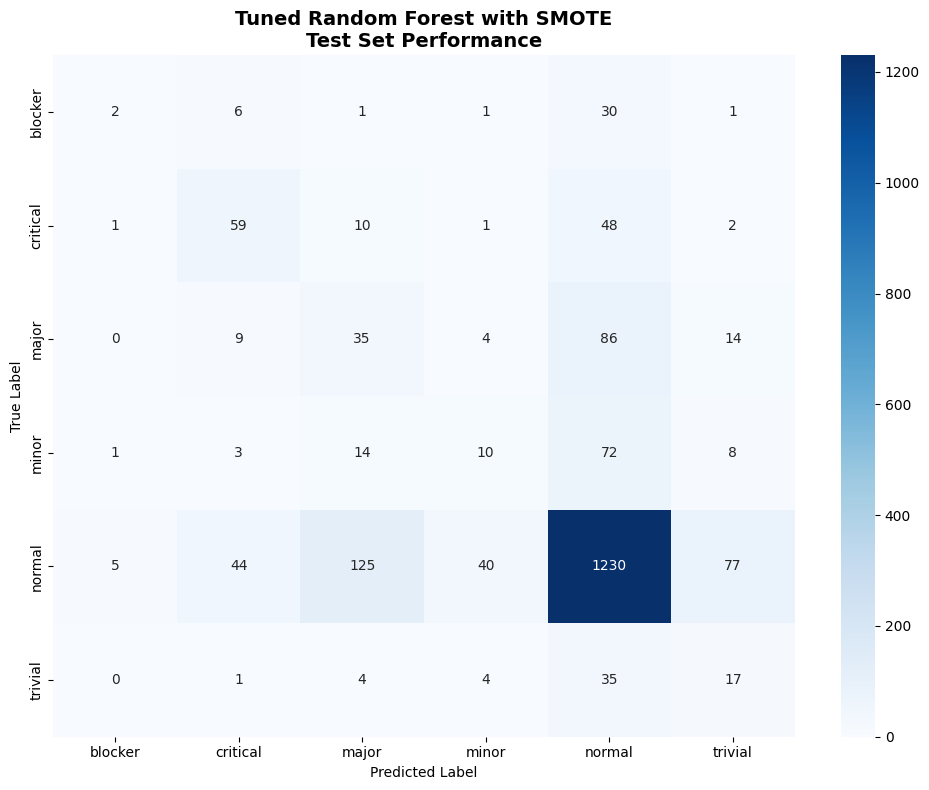

In [21]:
# Confusion Matrix
cm = confusion_matrix(y_test_original, y_pred_final, labels=sorted(label_encoder.classes_))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(label_encoder.classes_),
            yticklabels=sorted(label_encoder.classes_))
plt.title(f'Tuned {best_model_name} with SMOTE\nTest Set Performance', 
          fontweight='bold', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('../figures/confusion_matrix_tuned_final.png', dpi=300, bbox_inches='tight')
print("\n✅ Confusion matrix saved: ../figures/confusion_matrix_tuned_final.png")
plt.show()

In [22]:
baseline_f1_macro = 0.30  # From your previous SMOTE + Categorical approach
tuned_f1_macro = best_score

improvement = ((tuned_f1_macro - baseline_f1_macro) / baseline_f1_macro) * 100

print(f"\nBaseline (SMOTE + Categorical, default params):")
print(f"  CV F1-Macro: {baseline_f1_macro:.4f}")
print(f"\nTuned Model ({best_model_name}):")
print(f"  CV F1-Macro: {tuned_f1_macro:.4f}")
print(f"\nImprovement: {improvement:+.2f}%")


Baseline (SMOTE + Categorical, default params):
  CV F1-Macro: 0.3000

Tuned Model (Random Forest):
  CV F1-Macro: 0.3350

Improvement: +11.67%



FEATURE IMPORTANCE ANALYSIS

Top 20 Most Important Features:
Rank   Feature                        Importance  
----------------------------------------------------------------------
1      crash                          0.069133    
2      component                      0.018185    
3      product                        0.017774    
4      text_length                    0.015030    
5      release                        0.014186    
6      stack                          0.012318    
7      work                           0.011806    
8      useragent                      0.010349    
9      identifier                     0.009371    
10     talkback                       0.009140    
11     error                          0.008268    
12     actual                         0.008230    
13     rv                             0.007430    
14     load                           0.007385    
15     update                         0.007108    
16     bug                            0.006055    


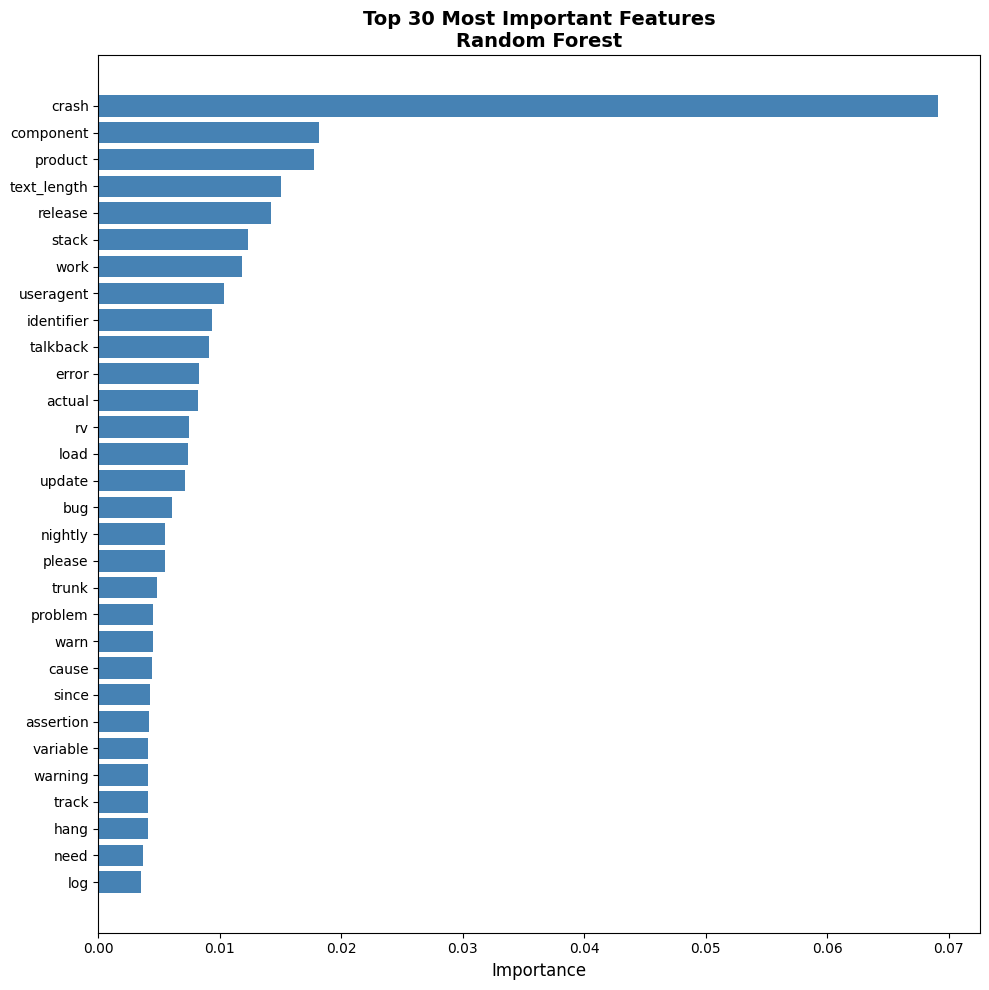

In [23]:
# Analysis of feature importance
if best_model_name in ['Random Forest', 'XGBoost']:
    print("\n" + "="*70)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*70)
    
    # Extract feature importance
    classifier = best_estimator.named_steps['classifier']
    feature_combiner = best_estimator.named_steps['feature_combiner']
    
    # Get feature names
    tfidf_features = feature_combiner.tfidf.get_feature_names_out()
    all_features = list(tfidf_features) + ['component', 'product', 'text_length']
    
    # Get importances
    importances = classifier.feature_importances_
    
    # Get top 30
    top_indices = np.argsort(importances)[-30:]
    top_features = [all_features[i] for i in top_indices]
    top_importances = importances[top_indices]
    
    print(f"\nTop 20 Most Important Features:")
    print(f"{'Rank':<6} {'Feature':<30} {'Importance':<12}")
    print("-"*70)
    for rank, (feat, imp) in enumerate(zip(reversed(top_features[-20:]), 
                                            reversed(top_importances[-20:])), 1):
        print(f"{rank:<6} {feat:<30} {imp:<12.6f}")
    
    # Plot
    plt.figure(figsize=(10, 10))
    plt.barh(range(len(top_features)), top_importances, color='steelblue')
    plt.yticks(range(len(top_features)), top_features)
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Top 30 Most Important Features\n{best_model_name}', 
              fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.savefig('../figures/feature_importance_tuned.png', dpi=300, bbox_inches='tight')
    print("\n✅ Feature importance plot saved: ../figures/feature_importance_tuned.png")
    plt.show()

In [24]:
# Create directories (if don't exist)
os.makedirs('../models', exist_ok=True)
os.makedirs('../results', exist_ok=True)

# Save best model AND label encoder together
model_data = {
    'model': best_estimator,
    'label_encoder': label_encoder,
    'label_mapping': label_mapping
}

model_filename = f'../models/best_model_{best_model_name.replace(" ", "_").lower()}_tuned.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(model_data, f)
print(f"✅ Best model + label encoder saved: {model_filename}")

✅ Best model + label encoder saved: ../models/best_model_random_forest_tuned.pkl


In [25]:
# Save tuning summary
summary_filename = '../results/hyperparameter_tuning_summary.txt'
with open(summary_filename, 'w', encoding='utf-8') as f:  # ← ADD encoding='utf-8'
    f.write("="*70 + "\n")
    f.write("HYPERPARAMETER TUNING SUMMARY\n")
    f.write("="*70 + "\n\n")
    
    f.write(f"Date: {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Dataset size: {len(data)} rows\n")
    f.write(f"Dev set: {len(X_dev)} samples\n")
    f.write(f"Test set: {len(X_test)} samples\n\n")
    
    f.write("Label Encoding:\n")
    for idx, label in enumerate(label_encoder.classes_):
        f.write(f"  {label} → {idx}\n")  # Now this arrow will work!
    f.write("\n")
    
    f.write("-"*70 + "\n")
    f.write("MODEL COMPARISON\n")
    f.write("-"*70 + "\n\n")
    
    for model_name, results in tuning_results.items():
        f.write(f"{model_name}:\n")
        f.write(f"  Best CV F1-Macro: {results['best_score']:.4f}\n")
        f.write(f"  Tuning Time: {results['time']/60:.2f} minutes\n")
        f.write(f"  Best Parameters:\n")
        for param, value in results['best_params'].items():
            f.write(f"    {param}: {value}\n")
        f.write("\n")
    
    f.write("="*70 + "\n")
    f.write(f"BEST MODEL: {best_model_name}\n")
    f.write(f"CV F1-Macro: {best_score:.4f}\n")
    f.write("="*70 + "\n\n")
    
    f.write("TEST SET PERFORMANCE:\n")
    f.write(classification_report(y_test_original, y_pred_final))

print(f"✅ Tuning summary saved: {summary_filename}")

✅ Tuning summary saved: ../results/hyperparameter_tuning_summary.txt


In [26]:
# Save detailed CV results
cv_results_filename = '../results/cv_results_detailed.csv'
cv_results_df = pd.DataFrame(tuning_results[best_model_name]['cv_results'])
cv_results_df.to_csv(cv_results_filename, index=False)
print(f"✅ Detailed CV results saved: {cv_results_filename}")

print("\n" + "="*70)
print("\n" + "="*70)
print("✅ HYPERPARAMETER TUNING COMPLETE!")
print("="*70)
print(f"\nTotal tuning time: {sum(r['time'] for r in tuning_results.values())/60:.2f} minutes")
print(f"\nBest model: {best_model_name}")
print(f"CV F1-Macro: {best_score:.4f}")
print(f"Model saved to: {model_filename}")

✅ Detailed CV results saved: ../results/cv_results_detailed.csv


✅ HYPERPARAMETER TUNING COMPLETE!

Total tuning time: 25.64 minutes

Best model: Random Forest
CV F1-Macro: 0.3350
Model saved to: ../models/best_model_random_forest_tuned.pkl
